In [1]:
pip install tensorflow keras opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [13]:
from sklearn.model_selection import train_test_split

In [5]:
# folder dataset
happy_folder = "dataset/happy/"
angry_folder = "dataset/angry/"
sad_folder = "dataset/sad/"

limit = 100

In [6]:
# print file paths for debugging
print("Happy folder files:", glob.glob(happy_folder + "*.jpg"))
print("Angry folder files:", glob.glob(angry_folder + "*.jpg"))
print("Sad folder files:", glob.glob(sad_folder + "*.jpg"))


Happy folder files: ['dataset/happy/aug-70-085.jpg', 'dataset/happy/aug-121-039.jpg', 'dataset/happy/aug-78-097.jpg', 'dataset/happy/aug-68-083.jpg', 'dataset/happy/aug-8-012.jpg', 'dataset/happy/002.jpg', 'dataset/happy/003.jpg', 'dataset/happy/017.jpg', 'dataset/happy/aug-18-024.jpg', 'dataset/happy/aug-149-073.jpg', 'dataset/happy/aug-154-078.jpg', 'dataset/happy/aug-80-099.jpg', 'dataset/happy/aug-22-028.jpg', 'dataset/happy/aug-145-069.jpg', 'dataset/happy/aug-92-003.jpg', 'dataset/happy/aug-151-075.jpg', 'dataset/happy/aug-0-001.jpg', 'dataset/happy/aug-93-004.jpg', 'dataset/happy/aug-81-101.jpg', 'dataset/happy/029.jpg', 'dataset/happy/001.jpg', 'dataset/happy/015.jpg', 'dataset/happy/028.jpg', 'dataset/happy/aug-52-066.jpg', 'dataset/happy/aug-69-084.jpg', 'dataset/happy/aug-103-019.jpg', 'dataset/happy/aug-96-008.jpg', 'dataset/happy/aug-89-112.jpg', 'dataset/happy/aug-126-047.jpg', 'dataset/happy/aug-140-063.jpg', 'dataset/happy/aug-102-018.jpg', 'dataset/happy/aug-97-009.jpg

In [7]:
# load images
images_happy = [cv2.imread(file) for file in glob.glob(happy_folder+"*.jpg")][:limit]
images_angry = [cv2.imread(file) for file in glob.glob(angry_folder+"*.jpg")][:limit]
images_sad = [cv2.imread(file) for file in glob.glob(sad_folder+"*.jpg")][:limit]

In [8]:
# images labeling
labels_happy = [0] * len(images_happy)
labels_angry = [1] * len(images_angry)
labels_sad = [2] * len(images_sad)

In [9]:
# checking data
happy_count = len(images_happy)
happy_count

100

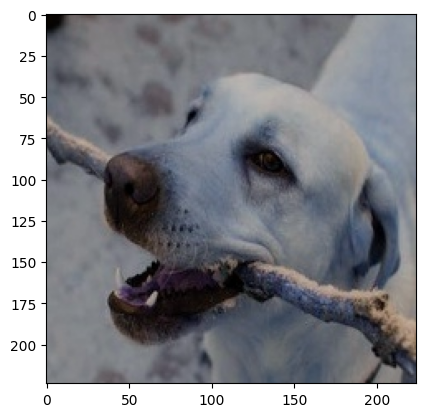

In [10]:
img = np.asarray(images_happy[99])
imgplot = plt.imshow(img)

In [32]:
# resize images to 64x64

common_size = (64,64)
images_happy = [cv2.resize(image, common_size) for image in images_happy]
images_angry = [cv2.resize(image, common_size) for image in images_angry]
images_sad = [cv2.resize(image, common_size) for image in images_sad]

In [33]:
# Concatenate images and labels
X = np.concatenate((images_happy, images_angry, images_sad), axis = 0)
y = np.concatenate((labels_happy, labels_angry, labels_sad), axis = 0)

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [35]:
X_train.shape

(240, 64, 64, 3)

In [36]:
y_train.shape

(240,)

In [76]:
def initialize_model():

    model = models.Sequential()

    model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(64, 64, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(16, activation='relu'))

    model.add(layers.Dense(3, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

In [77]:
# Training the model

model = initialize_model()

In [78]:
es = EarlyStopping(patience = 10, restore_best_weights= True)

history = model.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
3/3 [==============================] - 1s 153ms/step - loss: 7.4079 - accuracy: 0.3021 - val_loss: 5.2200 - val_accuracy: 0.3958
Epoch 2/25
3/3 [==============================] - 0s 119ms/step - loss: 3.7245 - accuracy: 0.3385 - val_loss: 6.3075 - val_accuracy: 0.3958
Epoch 3/25
3/3 [==============================] - 0s 118ms/step - loss: 3.5473 - accuracy: 0.3594 - val_loss: 2.9412 - val_accuracy: 0.3750
Epoch 4/25
3/3 [==============================] - 0s 118ms/step - loss: 2.0312 - accuracy: 0.3594 - val_loss: 2.0335 - val_accuracy: 0.4375
Epoch 5/25
3/3 [==============================] - 0s 118ms/step - loss: 1.8662 - accuracy: 0.3698 - val_loss: 2.1483 - val_accuracy: 0.3125
Epoch 6/25
3/3 [==============================] - 0s 129ms/step - loss: 1.3983 - accuracy: 0.4427 - val_loss: 1.7362 - val_accuracy: 0.4583
Epoch 7/25
3/3 [==============================] - 0s 116ms/step - loss: 1.3502 - accuracy: 0.4479 - val_loss: 1.6965 - val_accuracy: 0.3125
Epoch 8/25
3/3 [====

In [72]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # ----Loss----
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Validation'], loc= 'best')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ----Accuracy----
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'], loc= 'best')
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)
    
    if title:
        fig.suptitle(title)

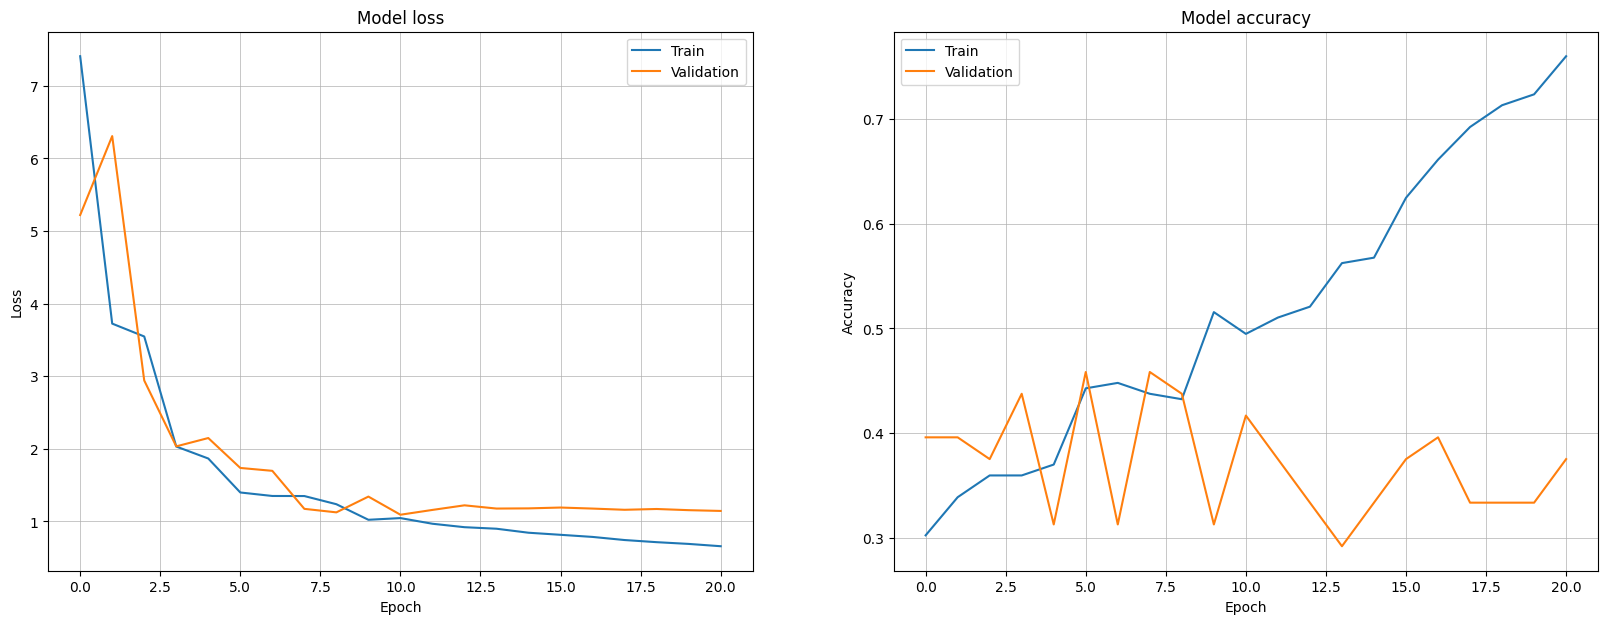

In [79]:
plot_loss_accuracy(history, title=None)

In [80]:
evaluation = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 19ms/step - loss: 1.1901 - accuracy: 0.3500


In [68]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 43.33 %
